# A triple pendulum

Note that this is not a physical pendulum (with non-vanishing moments of inertia) but a set of mass points.

## Imports

In [1]:
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from functools import partial

## Define basic variables (symbols)

We'll need all constants (masses and lengths, gravity) and we'll also get time and the three degrees of freedom (three angles).

In [2]:
# time
t = dynamicsymbols._t

# masses and lengths
m00, m01, m10, m11, m20, m21 = sp.symbols('m00 m01 m10 m11 m20 m21', positive=True)
l00, l01, l10, l11, l20, l21 = sp.symbols('l00 l01 l10 l11 l20 l21', positive=True)

# gravitational acceleration
g = sp.symbols('g', positive=True)

# angles. Zero means respective arm points straight down
phi0, phi1, phi2 = dynamicsymbols('phi_0 phi_1 phi_2')

## Derived coords

Build the radial coords of the arms relative to their mounts and the absolute locations of the weights.

In [3]:
# vectors from mounts to the masses with the mounts for the next
r00 = l00 * sp.Matrix([sp.sin(phi0), -sp.cos(phi0)])
r10 = l10 * sp.Matrix([sp.sin(phi1), -sp.cos(phi1)])
r20 = l20 * sp.Matrix([sp.sin(phi2), -sp.cos(phi2)])

# vectors from mounts to the counterweights
r01 = - r00
r11 = - r10
r21 = - r20

In [4]:
# these all point downwards for phi=0:
display(r00.subs({phi0: 0}).T)
display(r10.subs({phi1: 0}).T)
display(r20.subs({phi2: 0}).T)

Matrix([[0, -l00]])

Matrix([[0, -l10]])

Matrix([[0, -l20]])

In [5]:
# these all point upwards for phi=0:
display(r01.subs({phi0: 0}).T)
display(r11.subs({phi1: 0}).T)
display(r21.subs({phi2: 0}).T)

Matrix([[0, l00]])

Matrix([[0, l10]])

Matrix([[0, l20]])

In [6]:
# absolute locations

# mounts
x0 = sp.Matrix([0, 0])
x1 = x0 + r00
x2 = x1 + r10

# weights
x00 = x0 + r00
x01 = x0 + r01
x10 = x1 + r10
x11 = x1 + r11
x20 = x2 + r20
x21 = x2 + r21

In [7]:
# this should be fully downward
x20.subs({phi0: 0, phi1: 0, phi2: 0})

Matrix([
[               0],
[-l00 - l10 - l20]])

In [8]:
# this should point fully up
x20.subs({phi0: -sp.pi, phi1: -sp.pi, phi2: -sp.pi})

Matrix([
[              0],
[l00 + l10 + l20]])

## Kinetic energy

In [9]:
# velocities
v00 = x00.diff(t)
v01 = x01.diff(t)
v10 = x10.diff(t)
v11 = x11.diff(t)
v20 = x20.diff(t)
v21 = x21.diff(t)

In [10]:
T = sp.Rational(1, 2) * (
    m00 * v00.dot(v00)
    + m01 * v01.dot(v01)
    + m10 * v10.dot(v10)
    + m11 * v11.dot(v11)
    + m20 * v20.dot(v20)
    + m21 * v21.dot(v21)
)

## Potential energy

In [11]:
V = g * (
    m00 * x00[1]
    + m01 * x01[1]
    + m10 * x10[1]
    + m11 * x11[1]
    + m20 * x20[1]
    + m21 * x21[1]
)

## Lagrangian, Generalized Coordinates and Euler-Lagrange Equations

In [12]:
L = T - V

In [13]:
q = sp.Matrix([phi0, phi1, phi2])
qd = q.diff(t)
qdd = qd.diff(t)

In [14]:
eoms = sp.Matrix(
    [
        L.diff(qdj).diff(t)
        - L.diff(qj)
        for qj, qdj in zip(q, qd)
    ]
)

## Rewrite into linear equation

For solving the equations of motion, we rewrite them into the form
$$M\cdot\ddot{\vec{q}} = \vec{F}$$
with the square matrix $M=M(t, \vec{q}, \dot{\vec{q}})$ acting as a generalized mass, and the vector $\vec{F}=\vec{F}(t, \vec{q}, \dot{\vec{q}})$ is a generalized forcing.

In [15]:
M, F = sp.linear_eq_to_matrix(sp.simplify(sp.Matrix(eoms)), list(qdd))

In [16]:
print(M.shape, qdd.shape, F.shape)

(3, 3) (3, 1) (3, 1)


## Numerical evaluation

From all the relevant symbols, we build Python functions with the same signature:
```python
def f(t, q0, q1, q2, qd0, qd1, qd2, l00, l01, l10, l11, l20, l22, m00, m01, m10, m11, m20, m22, g):
    pass
```

In [17]:
params_symb = (l00, l01, l10, l11, l20, l21, m00, m01, m10, m11, m20, m21, g)

In [18]:
# locations of the mounts
x0_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x0)
x1_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x1)
x2_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x2)

# locations of the weights
x00_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x00)
x01_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x01)
x10_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x10)
x11_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x11)
x20_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x20)
x21_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, x21)

# velocities
v00_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, v00)
v01_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, v01)
v10_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, v10)
v11_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, v11)
v20_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, v20)
v21_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, v21)

# energy and lagrangian
T_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, T)
V_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, V)
L_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, L)

# gen. mass matrix and forcing vector
M_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, M)
F_ = sp.lambdify((t, ) + tuple(q) + tuple(qd) + params_symb, F)

Now, put some values for the lengths, masses, and gravity.

In [19]:
l = 0.2  # m
m_free = 0.3  # kg
m_mount = 0.2  # kg
params_vals = {
    l00: l, l01: l, l10: l, l11: l, l20: l, l21: l,
    m00: m_mount, m01: m_free, m10: m_mount, m11: m_free, m20: m_mount, m21: m_free,
    g: 9.81,
}
params_vals = {str(k): v for k, v in params_vals.items()}

## Visualization

Let's plot the state of the tripend for a few angles:

In [20]:
def plot_locations(t_val=0, q_vals=(0, 0, 0), qd_vals=(0, 0, 0), param_vals=None, ax=None, **kwargs):
    t_vals = (t_val, )
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = ax.get_figure()

    ax.plot(*x0_(*(t_vals + q_vals + qd_vals), **params_vals), 'kv', **kwargs)
    ax.plot(*x00_(*(t_vals + q_vals + qd_vals), **params_vals), 'ko', **kwargs)
    ax.plot(*x01_(*(t_vals + q_vals + qd_vals), **params_vals), 'ko', **kwargs)
    ax.plot(*np.array([
        x00_(*(t_vals + q_vals + qd_vals), **params_vals).T,
        x01_(*(t_vals + q_vals + qd_vals), **params_vals).T,
    ]).squeeze().T, 'k-', **kwargs)

    # ax.plot(*x1_(*(t_vals + q_vals + qd_vals), **params_vals), 'rv', **kwargs)
    ax.plot(*x10_(*(t_vals + q_vals + qd_vals), **params_vals), 'ro', **kwargs)
    ax.plot(*x11_(*(t_vals + q_vals + qd_vals), **params_vals), 'ro', **kwargs)
    ax.plot(*np.array([
        x10_(*(t_vals + q_vals + qd_vals), **params_vals).T,
        x11_(*(t_vals + q_vals + qd_vals), **params_vals).T,
    ]).squeeze().T, 'r-', **kwargs)
    
    # ax.plot(*x2_(*(t_vals + q_vals + qd_vals), **params_vals), 'bv', **kwargs)
    ax.plot(*x20_(*(t_vals + q_vals + qd_vals), **params_vals), 'bo', **kwargs)
    ax.plot(*x21_(*(t_vals + q_vals + qd_vals), **params_vals), 'bo', **kwargs)
    ax.plot(*np.array([
        x20_(*(t_vals + q_vals + qd_vals), **params_vals).T,
        x21_(*(t_vals + q_vals + qd_vals), **params_vals).T,
    ]).squeeze().T, 'b-', **kwargs)
    
    return fig, ax

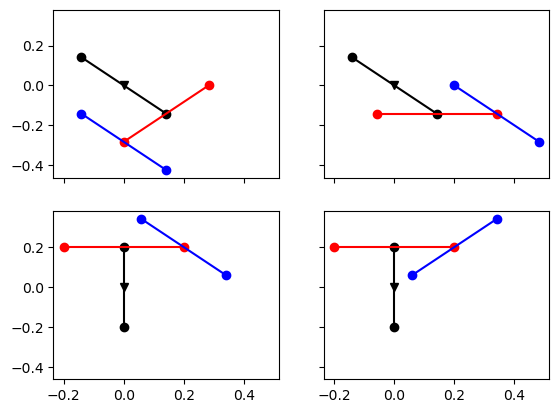

In [21]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

plot_locations(t_val=0, q_vals=(np.pi / 4, -np.pi / 4, np.pi / 4), qd_vals=(0, 0, 0), param_vals=params_vals, ax=ax[0, 0]);
plot_locations(t_val=0, q_vals=(np.pi / 4, 2 * np.pi / 4, np.pi / 4), qd_vals=(0, 0, 0), param_vals=params_vals, ax=ax[0, 1]);
plot_locations(t_val=0, q_vals=(np.pi, 2 * np.pi / 4, np.pi / 4), qd_vals=(0, 0, 0), param_vals=params_vals, ax=ax[1, 0]);
plot_locations(t_val=0, q_vals=(np.pi, 2 * np.pi / 4, -np.pi / 4), qd_vals=(0, 0, 0), param_vals=params_vals, ax=ax[1, 1]);

## Numerical solution

In [22]:
def rhs(t_num, y, params_vals=None):
    q_num  = y[0:3]
    qd_num = y[3:6]
    M_num = np.array(M_(t_num, *q_num, *qd_num, **params_vals), dtype=float)
    F_num = np.array(F_(t_num, *q_num, *qd_num, **params_vals), dtype=float).reshape(-1)

    qdd_num = np.linalg.solve(M_num, F_num)

    return np.concatenate([qd_num, qdd_num])

### run 1

In [23]:
q0   = np.array([np.pi / 2, 0, np.pi / 10])
qd0  = np.array([2 * np.pi / 20, 0, 0])
y0   = np.concatenate([q0, qd0])

t_span = (0.0, 60.0)
t_eval = np.arange(t_span[0], t_span[1], 0.01)

sol = solve_ivp(lambda tt, yy: rhs(tt, yy, params_vals), t_span, y0, atol=1e-04, t_eval=t_eval)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-02 ...  5.998e+01  5.999e+01]
        y: [[ 1.571e+00  1.572e+00 ... -1.003e+00 -1.034e+00]
            [ 0.000e+00  6.423e-06 ...  5.760e+00  5.812e+00]
            ...
            [ 0.000e+00  1.189e-03 ...  5.216e+00  5.199e+00]
            [ 0.000e+00  1.236e-02 ...  7.071e+00  7.066e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3086
     njev: 0
      nlu: 0

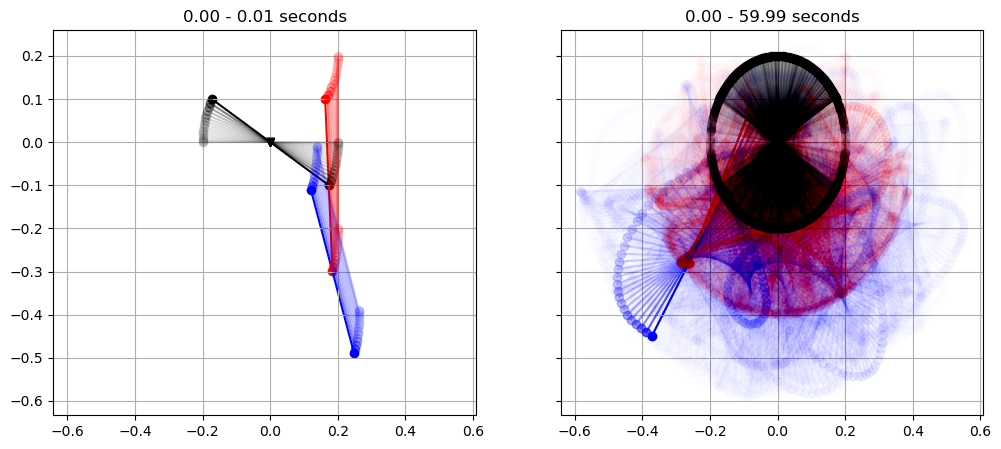

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# initial part
_ax = ax[0]
for _n in range(0, 20):
    n = 20 - _n
    alpha = 1 / (_n + 1)
    plot_locations(sol.t[n], tuple(sol.y[:3, n]), tuple(sol.y[3:, n]), params_vals, ax=_ax, alpha=alpha, zorder=10 * _n)
_ax.grid();
_ax.set_title(f"{sol.t[0]:.2f} - {sol.t[n]:.2f} seconds")

# all variability part
_ax = ax[1]
for _n in range(0, len(sol.t), 1):
    n = len(sol.t) - _n - 1
    alpha = 1 / (_n + 1) ** 0.7
    plot_locations(sol.t[n], tuple(sol.y[:3, n]), tuple(sol.y[3:, n]), params_vals, ax=_ax, alpha=alpha, zorder=10 * _n)
_ax.grid();
_ax.set_title(f"{sol.t[0]:.2f} - {sol.t[-1]:.2f} seconds");

### run 2: slightly more energy

In [25]:
q0   = np.array([np.pi / 2, 0, np.pi / 10])
qd0  = np.array([1.1 * 2 * np.pi / 20, 0, 0])
y0   = np.concatenate([q0, qd0])

t_span = (0.0, 60.0)
t_eval = np.arange(t_span[0], t_span[1], 0.01)

sol = solve_ivp(lambda tt, yy: rhs(tt, yy, params_vals), t_span, y0, atol=1e-04, t_eval=t_eval)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-02 ...  5.998e+01  5.999e+01]
        y: [[ 1.571e+00  1.573e+00 ...  4.049e-02  1.265e-01]
            [ 0.000e+00  6.647e-06 ... -1.966e-01 -2.013e-01]
            ...
            [ 0.000e+00  1.216e-03 ... -5.280e-01 -3.954e-01]
            [ 0.000e+00  1.235e-02 ... -2.380e-01 -6.923e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3200
     njev: 0
      nlu: 0

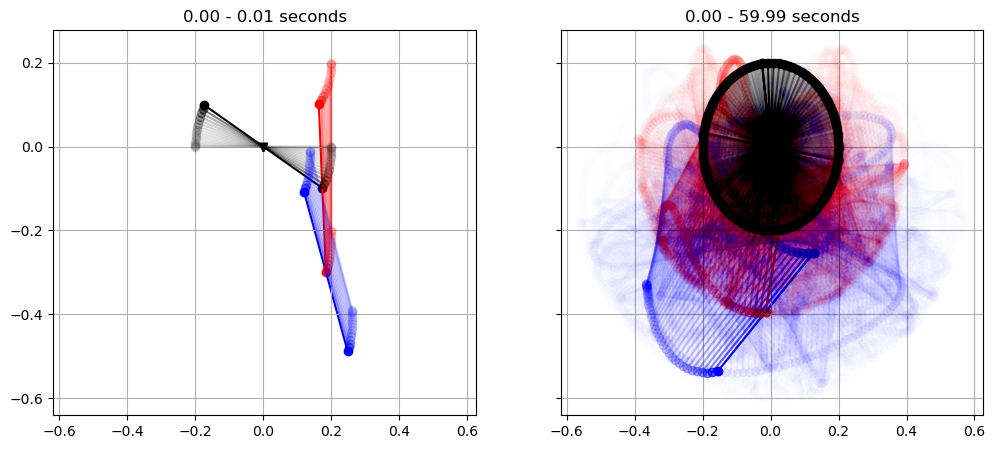

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# initial part
_ax = ax[0]
for _n in range(0, 20):
    n = 20 - _n
    alpha = 1 / (_n + 1)
    plot_locations(sol.t[n], tuple(sol.y[:3, n]), tuple(sol.y[3:, n]), params_vals, ax=_ax, alpha=alpha, zorder=10 * _n)
_ax.grid();
_ax.set_title(f"{sol.t[0]:.2f} - {sol.t[n]:.2f} seconds")

# all variability part
_ax = ax[1]
for _n in range(0, len(sol.t), 1):
    n = len(sol.t) - _n - 1
    alpha = 1 / (_n + 1) ** 0.7
    plot_locations(sol.t[n], tuple(sol.y[:3, n]), tuple(sol.y[3:, n]), params_vals, ax=_ax, alpha=alpha, zorder=10 * _n)
_ax.grid();
_ax.set_title(f"{sol.t[0]:.2f} - {sol.t[-1]:.2f} seconds");